In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor



In [2]:
df = pd.read_csv('modified_cropyield.csv')
df.head(3)

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Yield_tons_per_hectare,N,P,K,ph
0,South,Clay,Rice,992.673282,18.026142,True,True,8.527341,227.856348,18.632321,187.383842,8.392863
1,North,Loam,Barley,147.998025,29.794042,False,False,1.127443,156.926335,9.845947,169.432720,7.104303
2,North,Sandy,Soybean,986.866331,16.644190,False,True,6.517573,163.751011,9.815127,175.853055,6.133666


In [ ]:
wheat_df = df[df['Crop'] == 'Wheat'] 

print(wheat_df.head())
print(f"Total wheat rows: {len(wheat_df)}")

  Region Soil_Type   Crop  Rainfall_mm  Temperature_Celsius  Fertilizer_Used  \
3  South      Silt  Wheat   730.379174            31.620687             True   
5   West      Clay  Wheat   357.902357            31.593431            False   
7  North      Silt  Wheat   181.587861            26.752729             True   
8   West     Sandy  Wheat   395.048968            17.646199            False   
9  North     Peaty  Wheat   385.135314            21.656192            False   

   Irrigation_Used  Yield_tons_per_hectare           N          P           K  \
3             True                7.248251  177.816349  11.293325  170.945068   
5            False                2.652392  201.591628  23.298785  292.073167   
7            False                2.943716  191.809530  11.017052  221.358963   
8             True                3.707293  106.333052   7.872755  152.202173   
9            False                2.564442  126.909566  11.881729   61.004679   

         ph  
3  6.975311  
5  8

In [4]:
wheat_df = wheat_df.drop('Crop', axis=1)
print(wheat_df.columns)
df=wheat_df


Index(['Region', 'Soil_Type', 'Rainfall_mm', 'Temperature_Celsius',
       'Fertilizer_Used', 'Irrigation_Used', 'Yield_tons_per_hectare', 'N',
       'P', 'K', 'ph'],
      dtype='object')


In [ ]:


categorical_cols = ['Region', 'Soil_Type', 'Fertilizer_Used', 'Irrigation_Used']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  


In [6]:
with open('label_encoders_wheat.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
    

In [7]:
df.head(1)

,Region,Soil_Type,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Yield_tons_per_hectare,N,P,K,ph
3,2,5,730.379174,31.620687,1,1,7.248251,177.816349,11.293325,170.945068,6.975311


In [ ]:
X = df.drop('Yield_tons_per_hectare', axis=1)
y = df['Yield_tons_per_hectare']

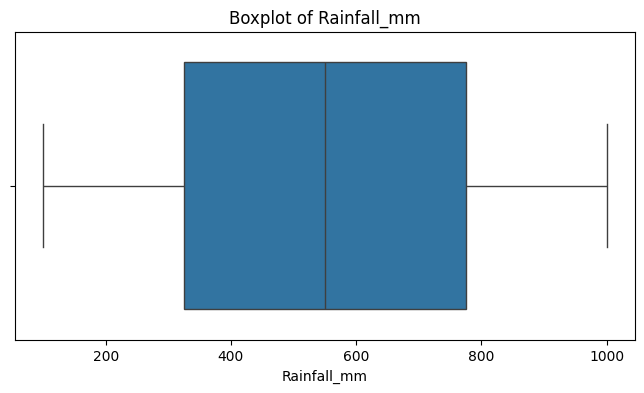

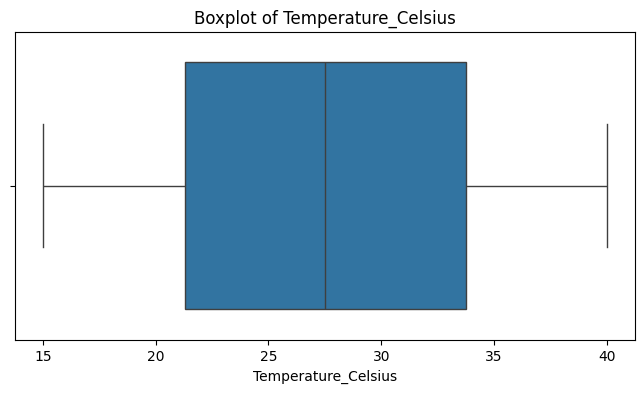

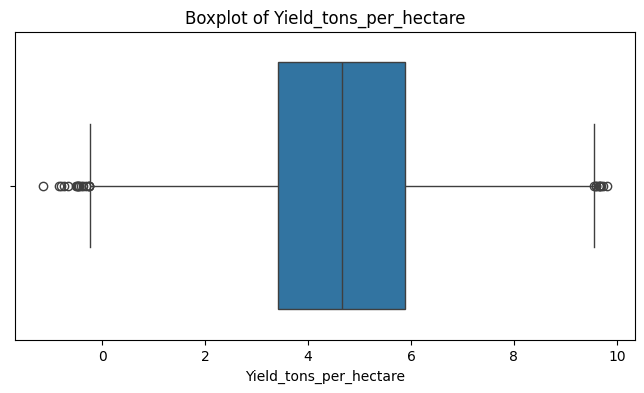

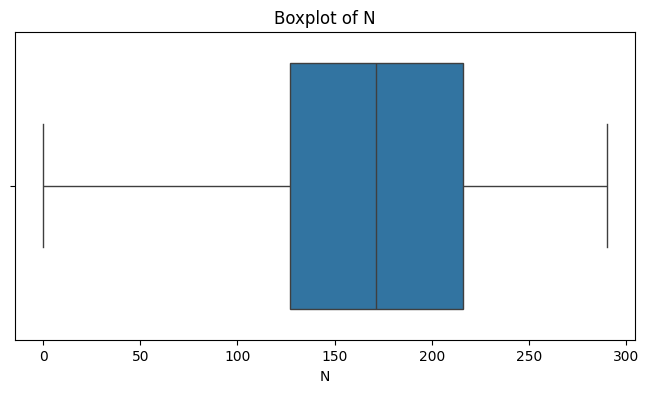

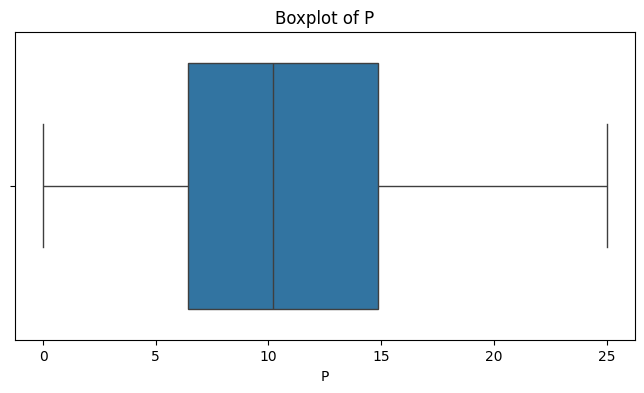

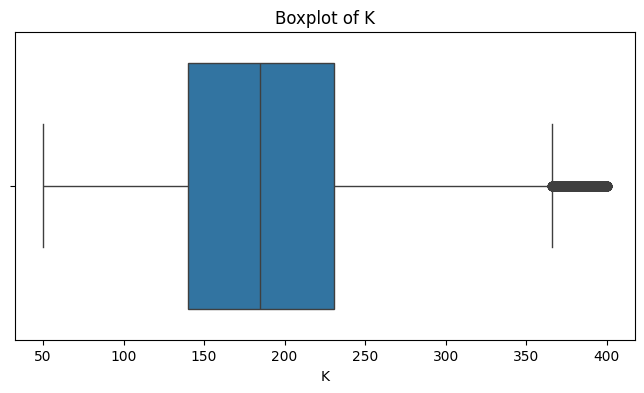

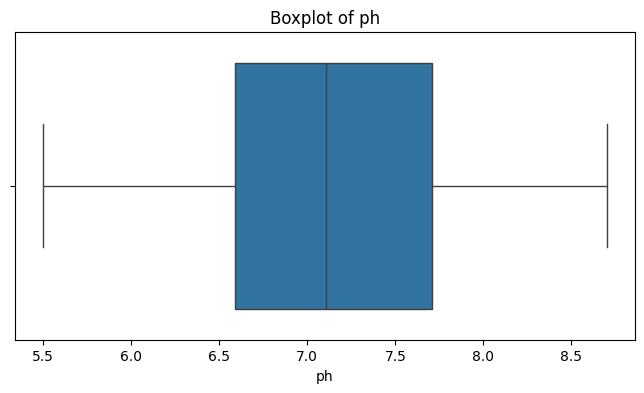

Number of outliers in 'K': 3737
Number of outliers in 'Yield_tons_per_hectare': 25


In [ ]:
numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Yield_tons_per_hectare', 'N', 'P', 'K', 'ph']

#Boxplots for numerical variables
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers.count()

print("Number of outliers in 'K':", count_outliers_iqr(df['K']))
print("Number of outliers in 'Yield_tons_per_hectare':", count_outliers_iqr(df['Yield_tons_per_hectare']))


In [9]:
# stratified sampling

df['K_bin'] = pd.qcut(df['K'], q=4, labels=False)
df['yield_bin'] = pd.qcut(df['Yield_tons_per_hectare'], q=4, labels=False)
df['strat_bin'] = df['K_bin'].astype(str) + '_' + df['yield_bin'].astype(str)

df_train_val, df_test = train_test_split(df, test_size=0.15, stratify=df['strat_bin'], random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.1765, stratify=df_train_val['strat_bin'], random_state=42)

# Drop auxiliary columns
df_train = df_train.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])
df_val = df_val.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])
df_test = df_test.drop(columns=['K_bin', 'yield_bin', 'strat_bin'])

X_train = df_train.drop('Yield_tons_per_hectare', axis=1)
y_train = df_train['Yield_tons_per_hectare']
X_val = df_val.drop('Yield_tons_per_hectare', axis=1)
y_val = df_val['Yield_tons_per_hectare']
X_test = df_test.drop('Yield_tons_per_hectare', axis=1)
y_test = df_test['Yield_tons_per_hectare']


print("X_train:", X_train.shape, " | y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   " | y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  " | y_test:", y_test.shape)



X_train: (116666, 10)  | y_train: (116666,)
X_val:   (25006, 10)  | y_val:   (25006,)
X_test:  (25001, 10)  | y_test: (25001,)


In [61]:
X_train.head(1)

,Region,Soil_Type,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,N,P,K,ph
496417,0,4,765.929244,22.450343,0,1,126.827285,9.207817,85.552089,7.007953


In [62]:
y_train.head(1)

496417    5.517837
Name: Yield_tons_per_hectare, dtype: float64

In [ ]:
rf_model2 = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model2.fit(X_train, y_train)


def print_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    std_err = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, Std Err: {std_err:.4f}")

y_train_pred = rf_model2.predict(X_train)
y_val_pred = rf_model2.predict(X_val)
y_test_pred = rf_model2.predict(X_test)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
# rf
# Train - R2: 0.9869, RMSE: 0.1939, MSE: 0.0376, MAE: 0.1535, Std Err: 0.1939
# Validation - R2: 0.9073, RMSE: 0.5179, MSE: 0.2683, MAE: 0.4131, Std Err: 0.5179
# Test - R2: 0.9066, RMSE: 0.5187, MSE: 0.2691, MAE: 0.4149, Std Err: 0.5187


Train - R2: 0.9869, RMSE: 0.1939, MSE: 0.0376, MAE: 0.1535, Std Err: 0.1939
Validation - R2: 0.9073, RMSE: 0.5179, MSE: 0.2683, MAE: 0.4131, Std Err: 0.5179
Test - R2: 0.9066, RMSE: 0.5187, MSE: 0.2691, MAE: 0.4149, Std Err: 0.5187


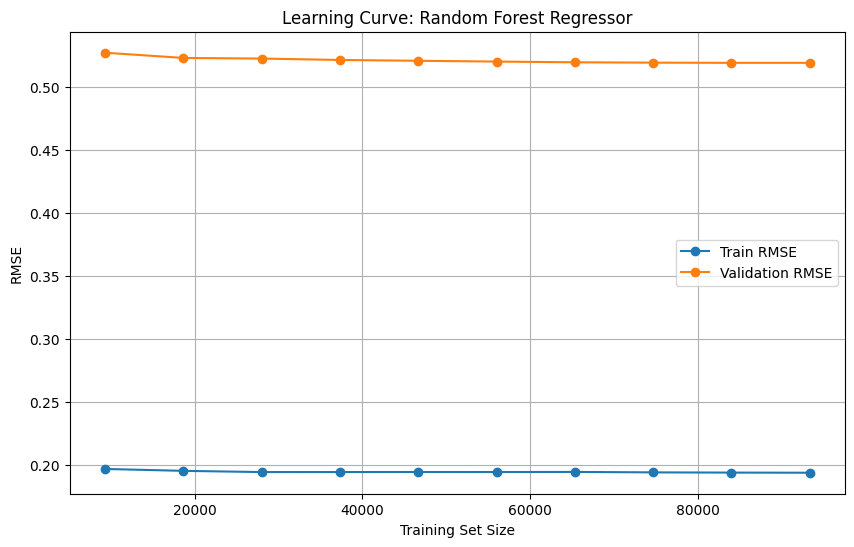

In [24]:
# rf_model2 learning curve
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

train_sizes, train_scores, val_scores = learning_curve(
    rf_model2,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, label="Train RMSE", marker='o')
plt.plot(train_sizes, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve: Random Forest Regressor")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# hyper param for rf
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

# already found, dont run



Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Default.DESKTOP-U1M7ONO\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
24 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Default.DESKTOP-U1M7ONO\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Default.DESKTOP-U1M7ONO\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\Default.DESKTOP-U1M7ONO\.venv\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constrai

Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}


In [ ]:
best_params = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 30,
    'random_state': 42
}

best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

y_train_pred = best_rf_model.predict(X_train)
y_val_pred = best_rf_model.predict(X_val)
y_test_pred = best_rf_model.predict(X_test)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")
# rf_tuned : 
# Train - R2: 0.9548, RMSE: 0.3600, MSE: 0.1296, MAE: 0.2825, Std Err: 0.3600
# Validation - R2: 0.9104, RMSE: 0.5094, MSE: 0.2594, MAE: 0.4062, Std Err: 0.5093
# Test - R2: 0.9101, RMSE: 0.5090, MSE: 0.2591, MAE: 0.4069, Std Err: 0.5090


Train - R2: 0.9548, RMSE: 0.3600, MSE: 0.1296, MAE: 0.2825, Std Err: 0.3600
Validation - R2: 0.9104, RMSE: 0.5094, MSE: 0.2594, MAE: 0.4062, Std Err: 0.5093
Test - R2: 0.9101, RMSE: 0.5090, MSE: 0.2591, MAE: 0.4069, Std Err: 0.5090


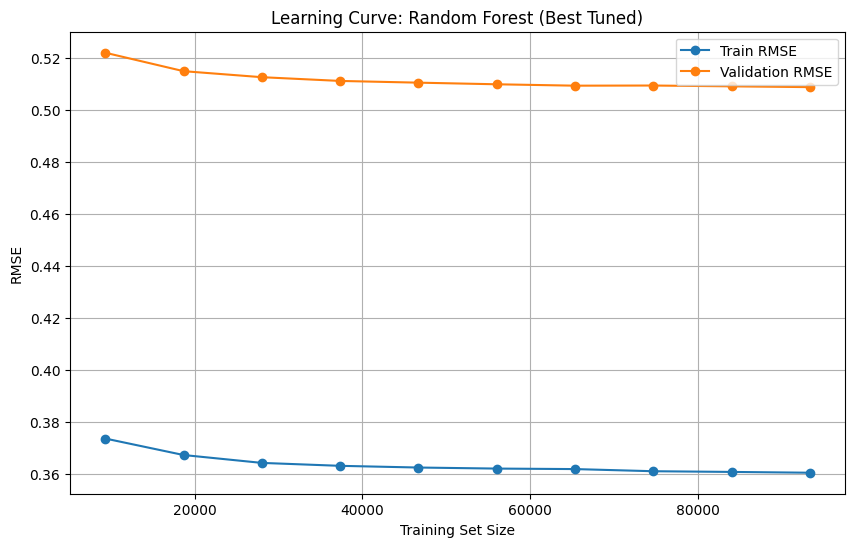

In [27]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse, label="Train RMSE", marker='o')
plt.plot(train_sizes, val_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve: Random Forest (Best Tuned)")
plt.legend()
plt.grid(True)
plt.show()


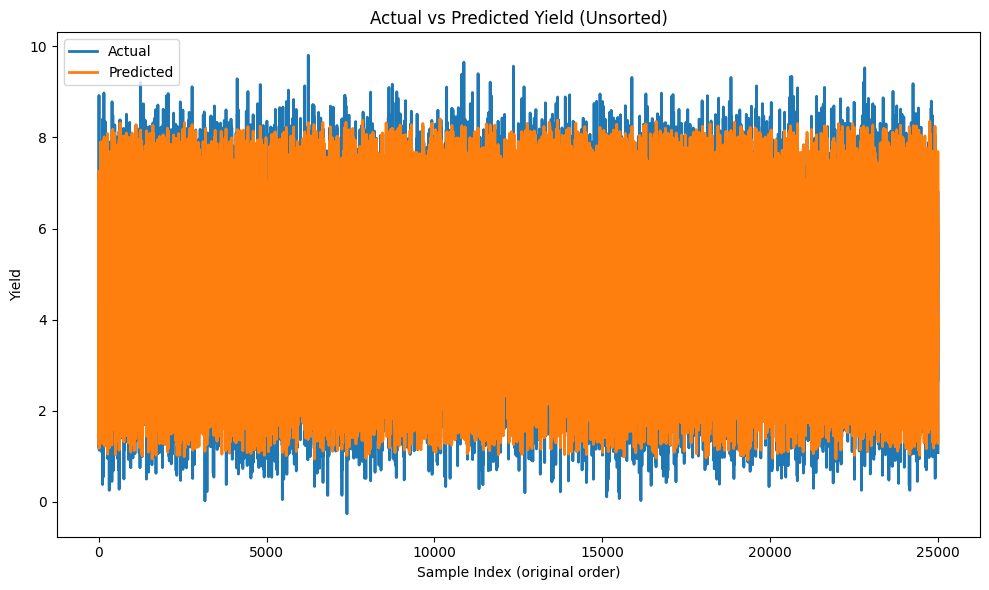

In [ ]:
y_val_pred = best_rf_model.predict(X_val)

plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual', linewidth=2)
plt.plot(y_val_pred, label='Predicted', linewidth=2)
plt.xlabel('Sample Index (original order)')
plt.ylabel('Yield')
plt.title('Actual vs Predicted Yield (Unsorted)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Best parameters found
best_params_ada = {
    'learning_rate': 1.0,
    'loss': 'square',
    'n_estimators': 200,
    'random_state': 42
}

best_ada = AdaBoostRegressor(**best_params_ada)
best_ada.fit(X_train, y_train)

def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, SD: {sd:.4f}")

print_metrics(y_train, best_ada.predict(X_train), "Train")
print_metrics(y_val, best_ada.predict(X_val), "Validation")
print_metrics(y_test, best_ada.predict(X_test), "Test")


# # Best AdaBoost params: {'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 200}
# Ada_tuned:
# Train - R2: 0.8847, RMSE: 0.5748, MAE: 0.4601, MSE: 0.3304, SD: 0.5747
# Validation - R2: 0.8856, RMSE: 0.5754, MAE: 0.4605, MSE: 0.3311, SD: 0.5753
# Test - R2: 0.8837, RMSE: 0.5788, MAE: 0.4628, MSE: 0.3350, SD: 0.5787

Train - R2: 0.8847, RMSE: 0.5748, MAE: 0.4601, MSE: 0.3304, SD: 0.5747
Validation - R2: 0.8856, RMSE: 0.5754, MAE: 0.4605, MSE: 0.3311, SD: 0.5753
Test - R2: 0.8837, RMSE: 0.5788, MAE: 0.4628, MSE: 0.3350, SD: 0.5787


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

# Fit model
gb_model.fit(X_train, y_train)

def print_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y_true - y_pred)
    print(f"{dataset_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, SD: {sd:.4f}")

print_metrics(y_train, gb_model.predict(X_train), "Train")
print_metrics(y_val, gb_model.predict(X_val), "Validation")
print_metrics(y_test, gb_model.predict(X_test), "Test")

# Gb_boost:
# Train - R2: 0.9130, RMSE: 0.4994, MAE: 0.3984, MSE: 0.2494, SD: 0.4994
# Validation - R2: 0.9123, RMSE: 0.5039, MAE: 0.4012, MSE: 0.2539, SD: 0.5039
# Test - R2: 0.9121, RMSE: 0.5034, MAE: 0.4019, MSE: 0.2534, SD: 0.5034

Train - R2: 0.9130, RMSE: 0.4994, MAE: 0.3984, MSE: 0.2494, SD: 0.4994
Validation - R2: 0.9123, RMSE: 0.5039, MAE: 0.4012, MSE: 0.2539, SD: 0.5039
Test - R2: 0.9121, RMSE: 0.5034, MAE: 0.4019, MSE: 0.2534, SD: 0.5034


In [11]:
with open('gb_model_wheat.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

print("Models and encoders saved successfully.")

Models and encoders saved successfully.


In [ ]:
input_data = {
    'Region': [1],
    'Soil_Type': [5],
    'Rainfall_mm': [820.460446],
    'Temperature_Celsius': [31.003539],
    'Fertilizer_Used': [0],
    'Irrigation_Used': [0],
    'N': [157.510061],
    'P': [16.875108],
    'K': [152.58378],
    'ph': [7.710211]
}

input_df = pd.DataFrame(input_data)

prediction = gb_model.predict(input_df)
print("Predicted Yield:", prediction[0])
# 4.761498 actual

# rf_model2 : Predicted Yield: 4.839013817044048
# best_rf_model: Predicted Yield: 4.781559360916001
# best_ada : Predicted Yield: 4.756925705653428
# gb_model : Predicted Yield: 4.7187794011703135

Predicted Yield: 4.7187794011703135


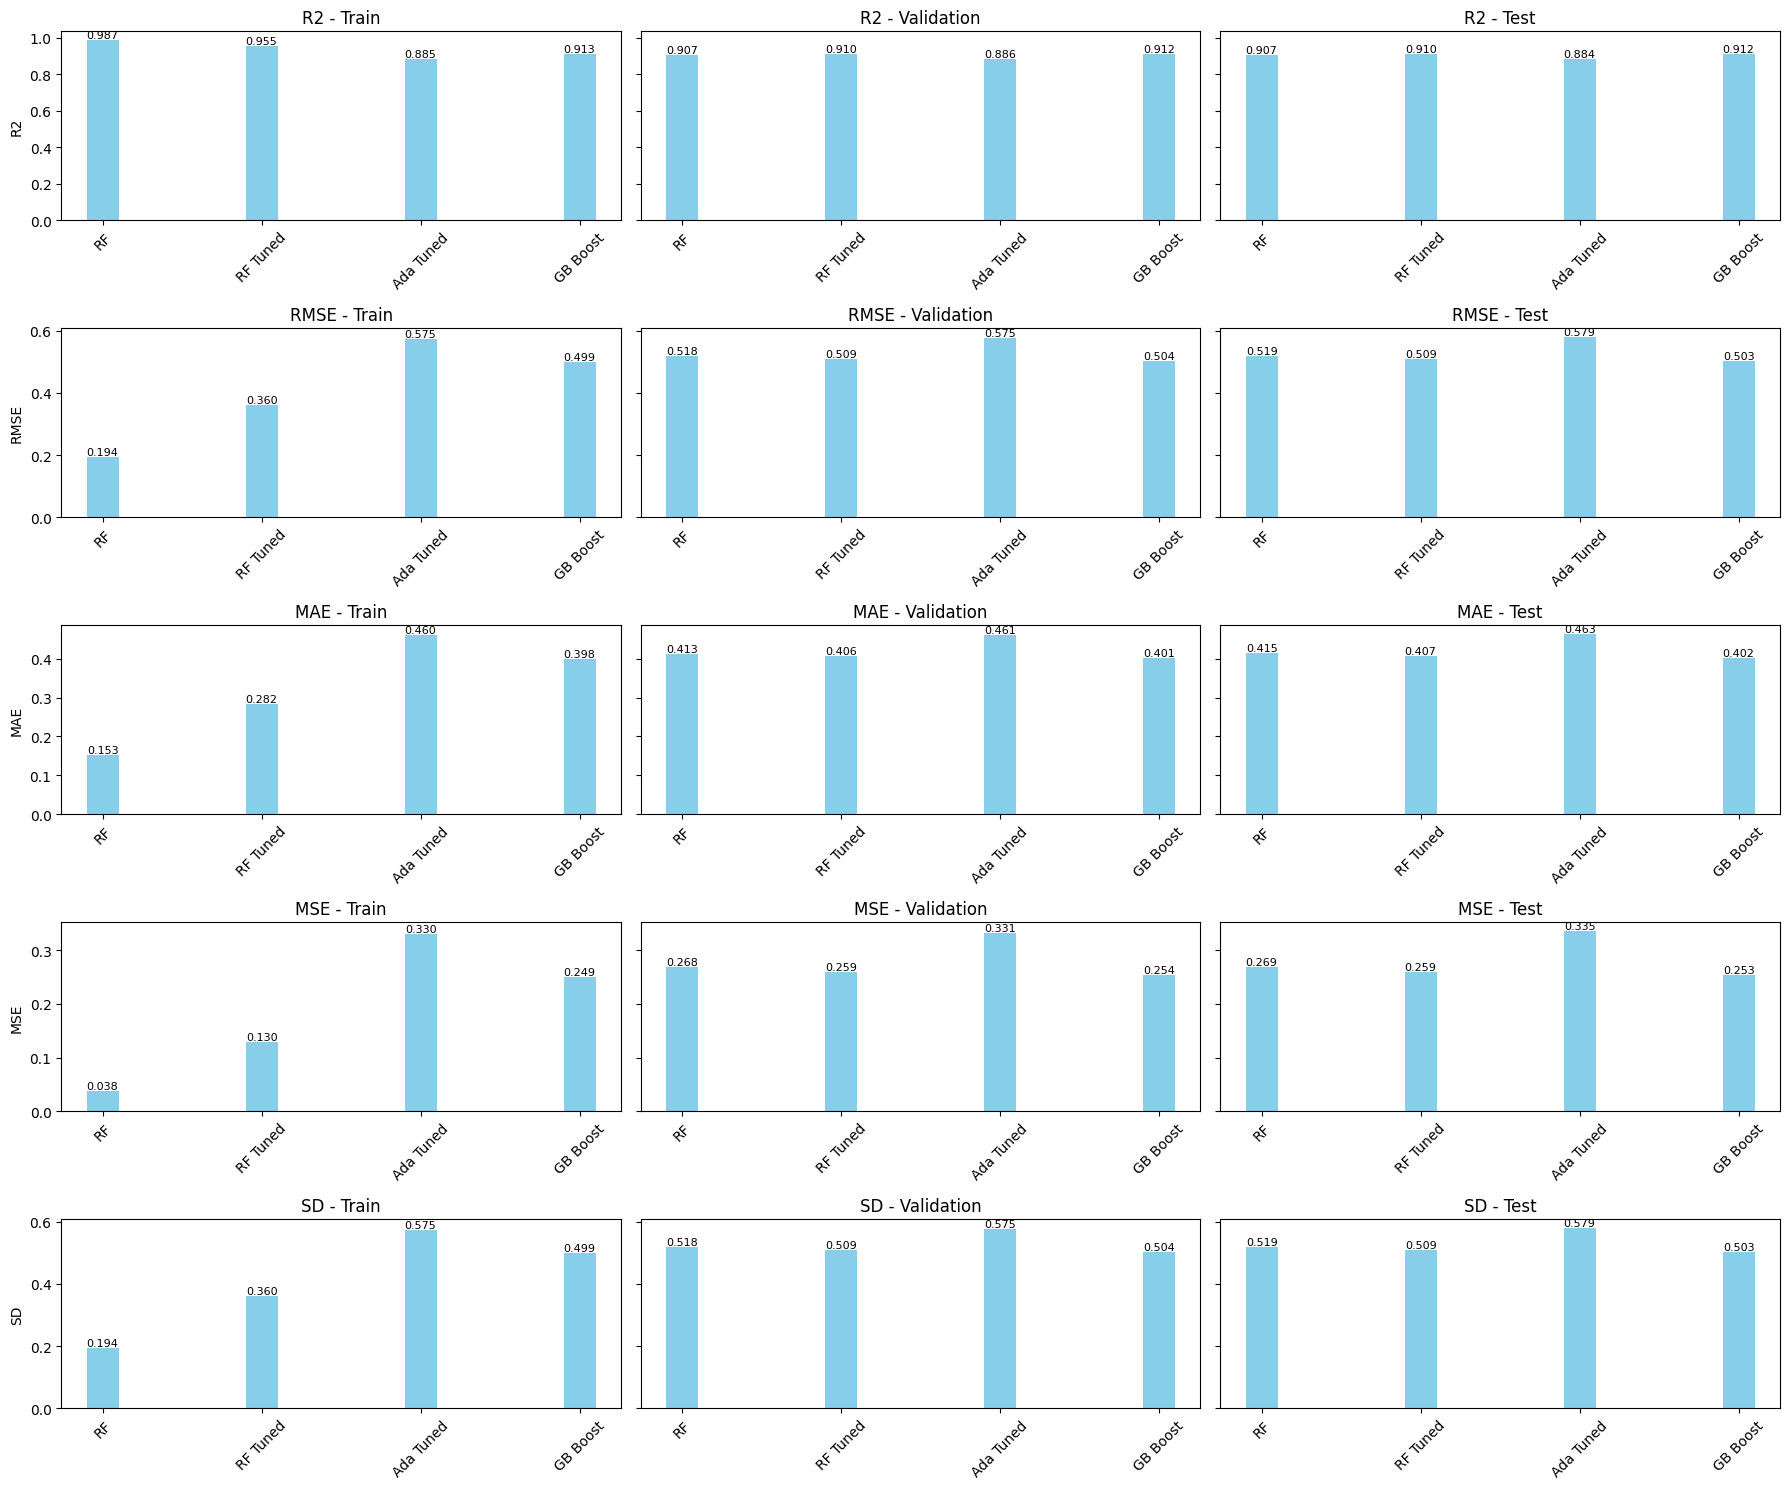

In [ ]:
data = {
    'Model': ['RF', 'RF Tuned', 'Ada Tuned', 'GB Boost'],
    'Train R2': [0.9869, 0.9548, 0.8847, 0.9130],
    'Validation R2': [0.9073, 0.9104, 0.8856, 0.9123],
    'Test R2': [0.9066, 0.9101, 0.8837, 0.9121],
    'Train RMSE': [0.1939, 0.36, 0.5748, 0.4994],
    'Validation RMSE': [0.5179, 0.5094, 0.5754, 0.5039],
    'Test RMSE': [0.5187, 0.5090, 0.5788, 0.5034],
    'Train MAE': [0.1535, 0.2825, 0.4601, 0.3984],
    'Validation MAE': [0.4131, 0.4062, 0.4605, 0.4012],
    'Test MAE': [0.4149, 0.4069, 0.4628, 0.4019],
    'Train MSE': [0.0376, 0.1296, 0.3304, 0.2494],
    'Validation MSE': [0.2683, 0.2594, 0.3311, 0.2539],
    'Test MSE': [0.2691, 0.2591, 0.3350, 0.2534],
    'Train SD': [0.1939, 0.3600, 0.5747, 0.4994],
    'Validation SD': [0.5179, 0.5093, 0.5753, 0.5039],
    'Test SD': [0.5187, 0.5090, 0.5787, 0.5034]
}

perf_mat = pd.DataFrame(data)
perf_mat.set_index('Model', inplace=True)

metrics = ['R2', 'RMSE', 'MAE', 'MSE', 'SD']
stages = ['Train', 'Validation', 'Test']

fig, axes = plt.subplots(len(metrics), len(stages), figsize=(18, 15), sharey='row')
bar_width = 0.2
x = np.arange(len(df.index)) 

for i, metric in enumerate(metrics):
    for j, stage in enumerate(stages):
        ax = axes[i, j]
        vals = df[f'{stage} {metric}']
        ax.bar(x, vals, width=bar_width, color='skyblue')
        ax.set_xticks(x)
        ax.set_xticklabels(df.index, rotation=45)
        ax.set_title(f'{metric} - {stage}')
        for idx, val in enumerate(vals):
            ax.text(idx, val, f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        if j == 0:
            ax.set_ylabel(metric)

plt.tight_layout()
plt.show()
